In [1]:
import scanpy as sc
import omicverse as ov
import pandas as pd
import numpy as np
import os
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import scvi


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.3, Tutorials: https://omicverse.readthedocs.io/


In [2]:
adata_new = sc.read_h5ad('/data/jiangjunyao/polyATAC/20250603_cellranger/1.merge_all_obj.h5ad')

In [5]:
adata = sc.read_h5ad('/data/jiangjunyao/polyATAC/polyATAC_rna.h5ad')
adata

AnnData object with n_obs × n_vars = 60355 × 32285
    obs: 'nCount_RNA', 'nFeature_RNA', 'Batch', 'ct_leiden', 'leiden', 'cell', 'nCount_Peak_ct', 'nFeature_Peak_ct', 'barcodes', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_Activity_DAR', 'nFeature_Activity_DAR', 'pgen', 'germ', 'detection'
    var: 'name'
    obsm: 'X_chromvar_pca', 'X_chromvar_pca_umap', 'X_pca', 'X_scbasset_umap', 'X_scvi', 'X_umap'

In [6]:
adata3 = adata.concatenate(adata_new)

In [7]:
sc.pp.highly_variable_genes(adata3, n_top_genes=2000, subset=True,flavor='seurat_v3')

In [8]:
scvi.model.SCVI.setup_anndata(
    adata3,
    batch_key='Batch')
model = scvi.model.SCVI(adata3,n_layers=3)
model.train()
SCVI_LATENT_KEY = "X_scVI"
latent = model.get_latent_representation()
adata3.obsm[SCVI_LATENT_KEY] = latent
SCVI_NORMALIZED_KEY = "scvi_normalized"
adata3.layers[SCVI_NORMALIZED_KEY] = model.get_normalized_expression(library_size=10e4)
### with batch correction
sc.pp.neighbors(adata3, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata3, min_dist=0.3)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 91/91: 100%|██████████| 91/91 [08:58<00:00,  5.68s/it, v_num=1, train_loss_step=861, train_loss_epoch=755]    

`Trainer.fit` stopped: `max_epochs=91` reached.


Epoch 91/91: 100%|██████████| 91/91 [08:58<00:00,  5.92s/it, v_num=1, train_loss_step=861, train_loss_epoch=755]


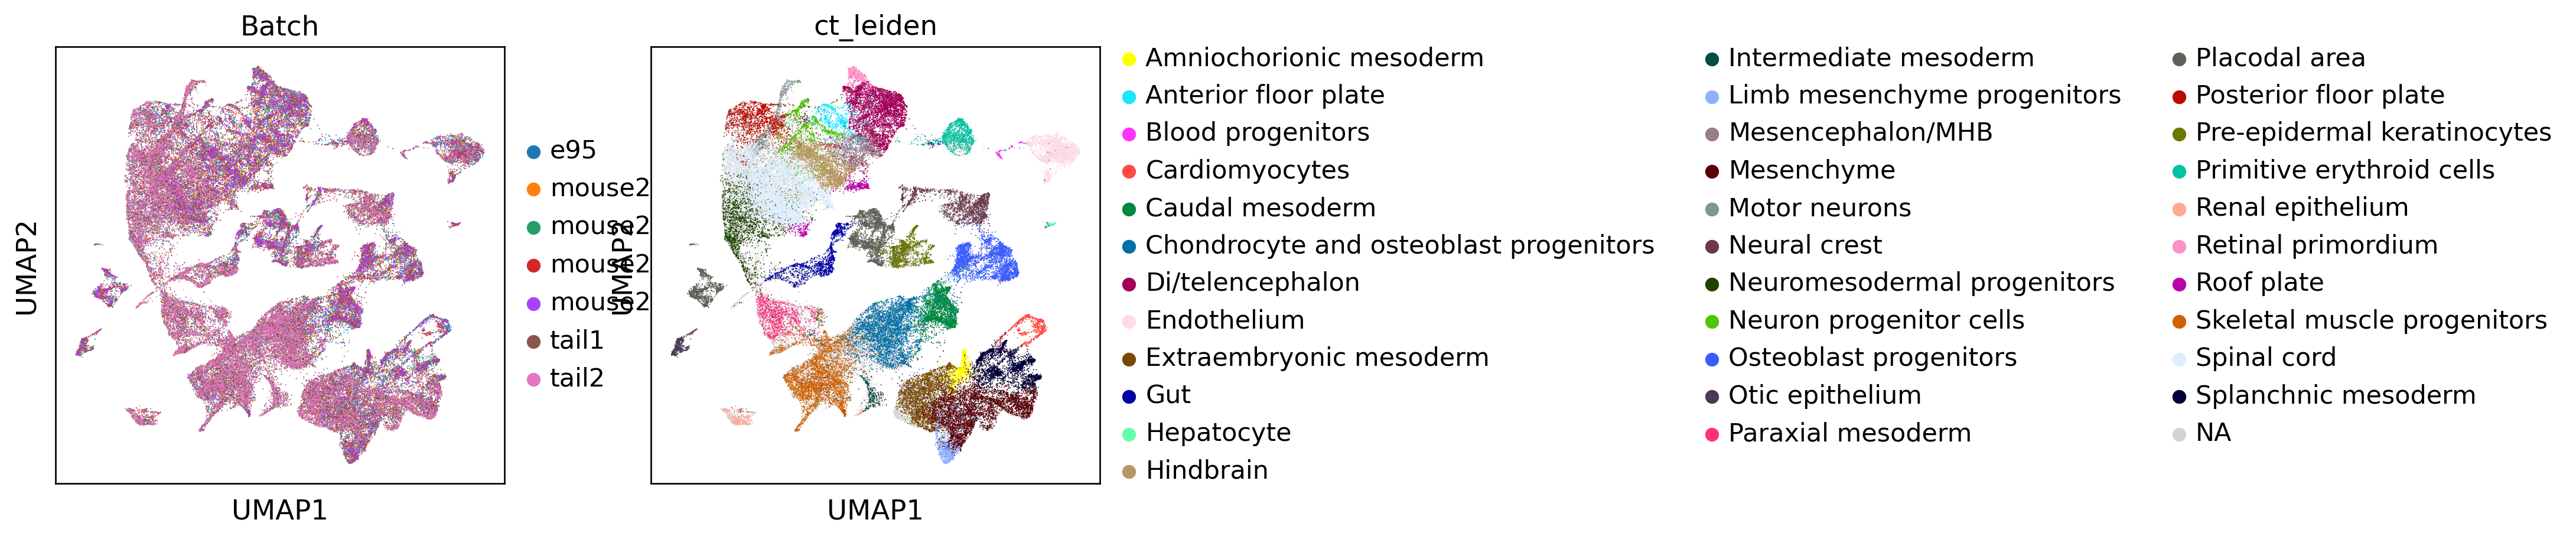

In [10]:
sc.pl.umap(adata3,color=['Batch','ct_leiden'])

In [12]:
from scipy.io import mmwrite
import pandas as pd
def write_10x(adata,outdir,out_meta = True,out_embed = True):
    mmwrite(outdir+"matrix.mtx", adata.X.T)
    cell = pd.DataFrame(list(adata.obs_names))
    gene = pd.DataFrame(list(adata.var_names))
    cell.to_csv(outdir+'barcodes.tsv',index=False,header=False)
    gene.to_csv(outdir + 'features.tsv', index=False, header=False)
    if out_meta:
        meta = pd.DataFrame(adata.obs.to_dict())
        meta.to_csv(outdir + 'meta.csv')
    if out_embed:
        embed = pd.DataFrame(adata.obsm['X_umap'])
        embed.to_csv(outdir+'embed.csv')
    if out_embed:
        embed = pd.DataFrame(adata.obsm['X_scVI'])
        embed.to_csv(outdir+'scvi.csv')
adata2 = adata.concatenate(adata_new)
adata2.obsm=adata3.obsm
write_10x(adata2,'/data/jiangjunyao/polyATAC/20250603_cellranger/merge_all_atac/')